##Task: Build a Transfer Learning model to detect face masks on humans

- Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import pathlib
from sklearn.metrics import classification_report, confusion_matrix
import shutil
import random
import IPython.display as display
from PIL import Image
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
!unzip -q /content/Face_mask_detection.zip -d /content/Face_mask_detection

In [ ]:
#! rm -r /content/Face_mask_detection

In [ ]:
source_dir = 'Face_mask_detection/data'

# Define the new base directory where you want the split data to go
# This will create 'train', 'validation', 'test' inside 'Face_mask_detection/split_dataset'
base_split_dir = 'Face_mask_detection/split_dataset'

# Create destination directories
train_dir = os.path.join(base_split_dir, 'train')
test_dir = os.path.join(base_split_dir, 'test')

# Define split ratios
train_ratio = 0.8
test_ratio = 0.2

# Ensure ratios sum to 1 (for verification)
assert train_ratio + test_ratio == 1.0, "Ratios must sum to 1.0"

# Get class names (e.g., 'with_mask', 'without_mask')
classes = [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]
print(f"Detected classes: {classes}")

# Create class subfolders inside train, val, test directories
for cls in classes:
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

    cls_path = os.path.join(source_dir, cls)
    images = [os.path.join(cls_path, img) for img in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, img))]
    random.shuffle(images) # Shuffle images for random split

    num_images = len(images)
    num_train = int(train_ratio * num_images)

    train_files = images[:num_train]
    test_files = images[num_train: ]

    print(f"Splitting class '{cls}': Train={len(train_files)}, Test={len(test_files)}")

    # Copy files to their respective new directories
    for f in train_files:
        shutil.copy(f, os.path.join(train_dir, cls))
    for f in test_files:
        shutil.copy(f, os.path.join(test_dir, cls))

print("\nData splitting complete. New structure created at:", base_split_dir)

# Verify the new structure (optional)
print("\nVerifying new structure:")
print(f"Train directory contents: {os.listdir(train_dir)}")
print(f"Test directory contents: {os.listdir(test_dir)}")

# Example of checking image counts in a class subfolder
print(f"Images in train/with_mask: {len(os.listdir(os.path.join(train_dir, 'with_mask')))}")

Detected classes: ['without_mask', 'with_mask']
Splitting class 'without_mask': Train=3062, Test=766
Splitting class 'with_mask': Train=2980, Test=745

Data splitting complete. New structure created at: Face_mask_detection/split_dataset

Verifying new structure:
Train directory contents: ['without_mask', 'with_mask']
Test directory contents: ['without_mask', 'with_mask']
Images in train/with_mask: 2980


In [ ]:
# Load the Image Training and Test Datasets from the train and test folders respectively. The
#size of each image is 128 x 128 x 3
#• Load training dataset using Keras ImageDataGenerator with validation_split=0.2
#• Load test dataset using Keras ImageDataGenerator


train_data_root = '/content/Face_mask_detection/split_dataset/train'
test_data_root = '/content/Face_mask_detection/split_dataset/test'

IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32
RANDOM_SEED = 42


train_val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Load train data

train_data = train_val_datagen.flow_from_directory(
    train_data_root,
    target_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    subset = 'training',
    seed = RANDOM_SEED
)

# Load validation data

validation_data = train_val_datagen.flow_from_directory(
    train_data_root,
    target_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    subset = 'validation',
    seed = RANDOM_SEED,
    shuffle=False
)

# test data

test_datagen = ImageDataGenerator(rescale=1./255)
test_data = test_datagen.flow_from_directory(
    test_data_root,
    target_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle=False
)

print(f"Found {train_data.samples} images belonging to {train_data.num_classes} classes.")
print(f"Found {validation_data.samples} images belonging to {validation_data.num_classes} classes.")
print(f"Found {test_data.samples} images belonging to {test_data.num_classes} classes.")

print(f"Indices {train_data.class_indices}")

Found 4834 images belonging to 2 classes.
Found 1208 images belonging to 2 classes.
Found 1511 images belonging to 2 classes.
Found 4834 images belonging to 2 classes.
Found 1208 images belonging to 2 classes.
Found 1511 images belonging to 2 classes.
Indices {'with_mask': 0, 'without_mask': 1}


Train root: Face_mask_detection/split_dataset/train
Test root: Face_mask_detection/split_dataset/test
Found 2980 images in train/with_mask.
Found 3062 images in train/without_mask.
Found 745 images in test/with_mask.
Found 766 images in test/without_mask.

Displaying an image from train/with_mask:


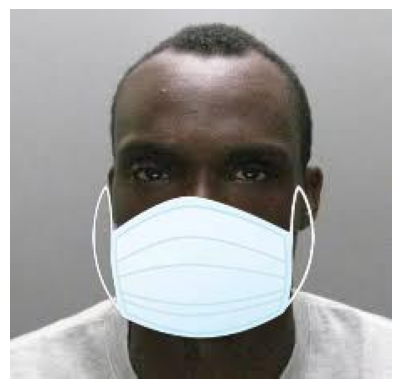


Displaying an image from train/without_mask:


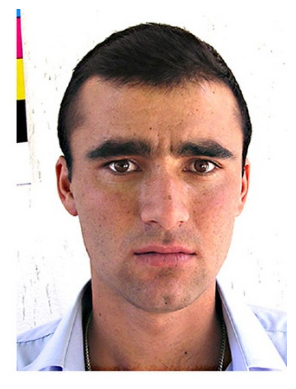


Displaying an image from test/with_mask:


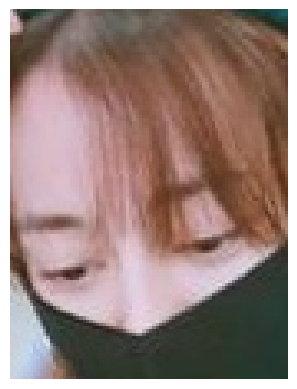


Displaying an image from test/without_mask:


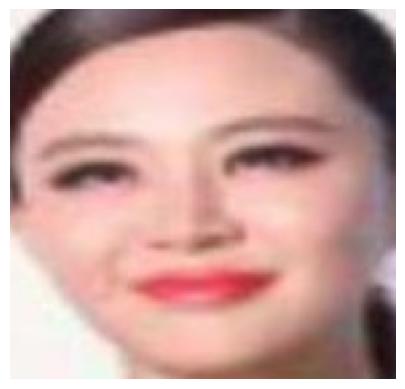

In [ ]:
import pathlib
from PIL import Image # Make sure Pillow is imported
import matplotlib.pyplot as plt # Make sure matplotlib is imported
import random # For getting random images if you want

# Assume these are correctly defined from your data loading setup:
train_data_root = 'Face_mask_detection/split_dataset/train'
test_data_root = 'Face_mask_detection/split_dataset/test'


# Define your display function
def display_images(image_path):
    img = Image.open(str(image_path))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# --- CORRECTED PATH GATHERING ---
train_data_root_path = pathlib.Path(train_data_root)
test_data_root_path = pathlib.Path(test_data_root)

# Corrected globs: The patterns are now relative to the root path you've defined
with_mask_train = list(train_data_root_path.glob('with_mask/*'))
without_mask_train = list(train_data_root_path.glob('without_mask/*'))

with_mask_test = list(test_data_root_path.glob('with_mask/*'))
without_mask_test = list(test_data_root_path.glob('without_mask/*'))
# --- END CORRECTED PATH GATHERING ---


# --- Debugging Prints (Highly Recommended to see if paths are found) ---
print(f"Train root: {train_data_root_path}")
print(f"Test root: {test_data_root_path}")
print(f"Found {len(with_mask_train)} images in train/with_mask.")
print(f"Found {len(without_mask_train)} images in train/without_mask.")
print(f"Found {len(with_mask_test)} images in test/with_mask.")
print(f"Found {len(without_mask_test)} images in test/without_mask.")

if len(with_mask_train) > 0:
    print("\nDisplaying an image from train/with_mask:")
    display_images(with_mask_train[0]) # Display the first image

if len(without_mask_train) > 0:
    print("\nDisplaying an image from train/without_mask:")
    # Using index 4 for demonstration, but safer to use 0 or random
    display_images(without_mask_train[min(4, len(without_mask_train) - 1)]) # Use min to prevent IndexError

if len(with_mask_test) > 0:
    print("\nDisplaying an image from test/with_mask:")
    display_images(with_mask_test[0])

if len(without_mask_test) > 0:
    print("\nDisplaying an image from test/without_mask:")
    # Using index 3 for demonstration, but safer to use 0 or random
    display_images(without_mask_test[min(3, len(without_mask_test) - 1)]) # Use min to prevent IndexError

In [ ]:
from tensorflow.keras.models import Model
input_tensor = tf.keras.layers.Input(shape=(128, 128, 3))

efficientnet = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=input_tensor)
efficientnet.trainable = False


x = efficientnet.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(255, activation='relu')(x)
x = Dropout(0.2)(x)
output_tensor = tf.keras.layers.Dense(2, activation='softmax')(x)

model1 = Model(inputs=efficientnet.input, outputs=output_tensor)

model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model1.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_8         │ (None, 128, 128,  │          0 │ input_layer_7[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_4     │ (None, 128, 128,  │          7 │ rescaling_8[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_9         │ (None, 128, 128,  │          0 │ normalization_4[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 129, 129,  │          0 │ rescaling_9[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 64, 64,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 64, 64,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 64, 64,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 64, 64,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 64, 64,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 64, 64,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 64, 64,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 64, 64,    │        512 │ block1a_se_excit

 Total params: 4,213,797 (16.07 MB)

 Trainable params: 164,226 (641.51 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
earlystopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=1, min_lr=1e-6)

In [ ]:
epochs = 25

history1 = model1.fit(
    train_data,
    steps_per_epoch=train_data.samples // BATCH_SIZE,
    validation_data=validation_data,
    validation_steps=validation_data.samples // BATCH_SIZE,
    epochs=epochs,
    callbacks = [earlystopping, reduce_lr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1146']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


 6/94 ━━━━━━━━━━━━━━━━━━━━ 16s 182ms/step - accuracy: 0.5600 - loss: 0.7724

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


94/94 ━━━━━━━━━━━━━━━━━━━━ 80s 626ms/step - accuracy: 0.5060 - loss: 0.7461 - val_accuracy: 0.4953 - val_loss: 0.6932 - learning_rate: 0.0010
Epoch 2/25
 1/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.3750 - loss: 0.7203

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


94/94 ━━━━━━━━━━━━━━━━━━━━ 16s 172ms/step - accuracy: 0.3750 - loss: 0.7203 - val_accuracy: 0.4953 - val_loss: 0.6933 - learning_rate: 0.0010
Epoch 3/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 35s 377ms/step - accuracy: 0.4843 - loss: 0.6959 - val_accuracy: 0.5047 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 4/25
 1/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6250 - loss: 0.6913
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
94/94 ━━━━━━━━━━━━━━━━━━━━ 16s 173ms/step - accuracy: 0.6250 - loss: 0.6913 - val_accuracy: 0.5047 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 5/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 35s 377ms/step - accuracy: 0.4955 - loss: 0.6933 - val_accuracy: 0.5047 - val_loss: 0.6931 - learning_rate: 2.0000e-04
Epoch 6/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 16s 172ms/step - accuracy: 0.5938 - loss: 0.6880 - val_accuracy: 0.5047 - val_loss: 0.6931 - learning_rate: 2.0000e-04
Epoch 7/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.5186 - loss: 0.6929
E

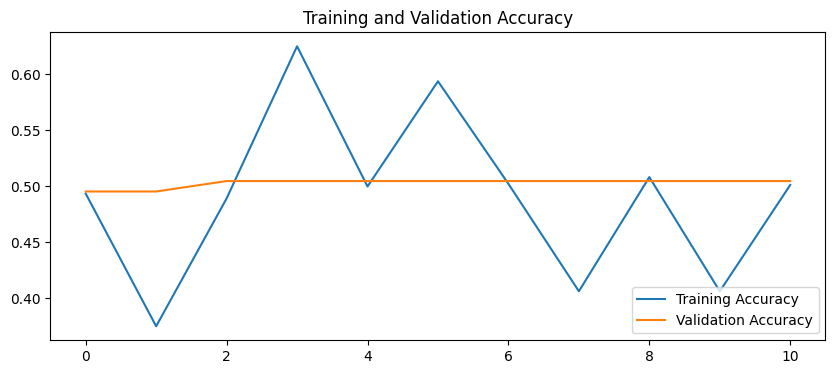

In [ ]:
# Plot training and validation accuracy and loss against epochs
epochs = 11
train_acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
train_loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(10, 4))
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.legend(loc='lower right')
plt.show()

# ResNet50

In [ ]:
input_tensor = tf.keras.layers.Input(shape=(128, 128, 3))

resnet = ResNet50(include_top=False, weights='imagenet', input_tensor=input_tensor)

resnet.trainable = False

x = resnet.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(255, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output_tensor = tf.keras.layers.Dense(2, activation='softmax')(x)

model2 = Model(inputs=resnet.input, outputs=output_tensor)

model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer_11[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 24,143,233 (92.10 MB)

 Trainable params: 555,521 (2.12 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
epochs = 25
history2 = model2.fit(
    train_data,
    steps_per_epoch=train_data.samples // BATCH_SIZE,
    validation_data=validation_data,
    validation_steps=validation_data.samples // BATCH_SIZE,
    epochs=epochs,
    callbacks = [earlystopping, reduce_lr]
)

Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1930']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


119/151 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.5094 - loss: 0.7932

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


151/151 ━━━━━━━━━━━━━━━━━━━━ 31s 121ms/step - accuracy: 0.5138 - loss: 0.7815 - val_accuracy: 0.5287 - val_loss: 0.6951 - learning_rate: 0.0010
Epoch 2/25
  1/151 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5625 - loss: 0.7016

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5625 - loss: 0.7016 - val_accuracy: 0.5135 - val_loss: 0.6951 - learning_rate: 0.0010
Epoch 3/25
151/151 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - accuracy: 0.5402 - loss: 0.6935 - val_accuracy: 0.4282 - val_loss: 0.7007 - learning_rate: 0.0010
Epoch 4/25
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4688 - loss: 0.7775 - val_accuracy: 0.4291 - val_loss: 0.7005 - learning_rate: 0.0010
Epoch 5/25
151/151 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.5731 - loss: 0.6799 - val_accuracy: 0.4392 - val_loss: 0.7025 - learning_rate: 0.0010
Epoch 6/25
  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5312 - loss: 0.6876
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5312 - loss: 0.6876 - val_accuracy: 0.4383 - val_loss: 0.7030 - learning_rate: 0.0010
Epoch 7/25
151/151 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - accuracy: 0.5640 - loss: 0.6761 - val_accu

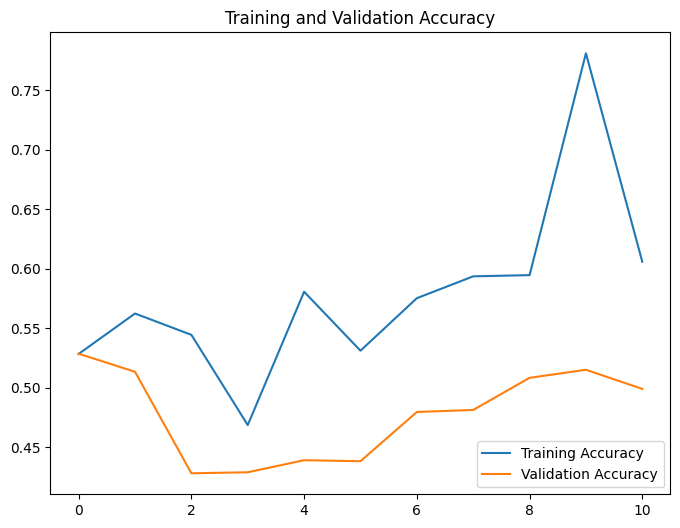

In [ ]:
# Plot with epochs

epochs = 11

train_acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
train_loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(8, 6))
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.legend(loc='lower right')
plt.show()

## Obseration

- The model using EfficientB0 is not learning
- ResNet50 is performing better than EfficientB0